In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import warnings

warnings.filterwarnings('ignore')

def clean_and_preprocess_data(df, remove_outliers=True):
    columns_to_drop = [
        'application_type', 'emp_title', 'member_id', 'issue_date',
        'last_credit_pull_date', 'last_payment_date', 'next_payment_date'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    def convert_emp_length(emp_length):
        if isinstance(emp_length, str):
            if '< 1 year' in emp_length:
                return 0.0
            elif '10+ years' in emp_length:
                return 10.0
            else:
                try:
                    return float(emp_length.split(' ')[0])
                except ValueError:
                    return np.nan
        return np.nan

    if 'emp_length' in df.columns:
        df['emp_length_num'] = df['emp_length'].apply(convert_emp_length)
        df = df.drop(columns=['emp_length'], errors='ignore')

    imputer = SimpleImputer(strategy='mean')
    numerical_cols = [
        'annual_income', 'dti', 'installment', 'int_rate', 
        'loan_amount', 'total_acc', 'total_payment', 'emp_length_num'
    ]
    existing_numerical_cols = [col for col in numerical_cols if col in df.columns]
    df[existing_numerical_cols] = imputer.fit_transform(df[existing_numerical_cols])

    initial_shape = df.shape
    df = df.drop_duplicates()
    final_shape = df.shape
    print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows.")

    if remove_outliers:
        for col in existing_numerical_cols:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    if 'int_rate' in df.columns and 'loan_amount' in df.columns:
        df['interest_to_loan_ratio'] = df['int_rate'] / (df['loan_amount'] + 1e-5)

    if 'installment' in df.columns and 'loan_amount' in df.columns:
        df['installment_to_loan_ratio'] = df['installment'] / (df['loan_amount'] + 1e-5)

    return df

data = pd.read_csv('train.csv')
data = clean_and_preprocess_data(data)

label_encoder = LabelEncoder()
data['grade_encoded'] = label_encoder.fit_transform(data['grade'])

X = data.drop(columns=['grade', 'grade_encoded'], errors='ignore')
y = data['grade_encoded']


categorical_cols = ['address_state', 'home_ownership', 'loan_status', 'purpose', 'term', 'verification_status']
target_encoder = TargetEncoder(cols=categorical_cols)
X[categorical_cols] = target_encoder.fit_transform(X[categorical_cols], y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)


scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.fit_transform(X_test_resampled)



Removed 0 duplicate rows.


In [ ]:
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='roc_auc_ovr',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_scaled, y_resampled)

best_xgb = CalibratedClassifierCV(estimator=random_search.best_estimator_, method='isotonic')
best_xgb.fit(X_scaled, y_resampled)

y_pred = best_xgb.predict(X_test_scaled)
y_prob = best_xgb.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test_resampled, y_pred)
roc_auc = roc_auc_score(y_test_resampled, y_prob, multi_class='ovr')

print(f"Training Set Accuracy: {accuracy:.4f}")
print(f"Training Set AUC-ROC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_resampled, y_pred, target_names=label_encoder.classes_))



In [21]:

print(f"Training Set Accuracy: {accuracy:.4f}")
print(f"Training Set AUC-ROC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_resampled, y_pred, target_names=label_encoder.classes_))

Training Set Accuracy: 0.4574
Training Set AUC-ROC: 0.8505

Classification Report:
              precision    recall  f1-score   support

           A       0.62      0.80      0.70       972
           B       0.41      0.35      0.38       972
           C       0.45      0.38      0.42       972
           D       0.38      0.41      0.40       972
           E       0.33      0.32      0.32       972
           F       0.39      0.34      0.36       972
           G       0.54      0.60      0.57       972

    accuracy                           0.46      6804
   macro avg       0.45      0.46      0.45      6804
weighted avg       0.45      0.46      0.45      6804



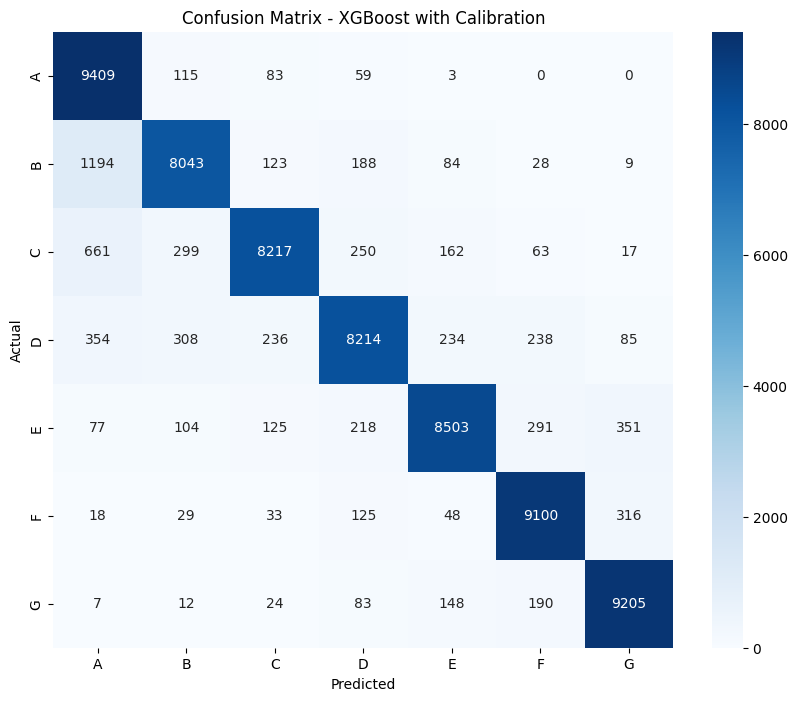

In [20]:
m = confusion_matrix(y_test_resampled, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost with Calibration')
plt.show()



In [18]:
y_pred

array([2, 0, 0, ..., 6, 6, 5], shape=(6804,))

In [19]:

test_data = pd.read_csv('test.csv')
id_column = 'member_id' if 'member_id' in test_data.columns else 'id'
ids = test_data[id_column]
test_data = clean_and_preprocess_data(test_data, remove_outliers=False)

X_test_final = test_data.drop(columns=['grade', 'grade_encoded'], errors='ignore')
X_test_final[categorical_cols] = target_encoder.transform(X_test_final[categorical_cols])
X_test_scaled = scaler.transform(X_test_final)

y_test_pred = best_xgb.predict(X_test_scaled)
grades = label_encoder.inverse_transform(y_test_pred)

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded_grades = one_hot_encoder.fit_transform(grades.reshape(-1, 1))
grade_columns = one_hot_encoder.categories_[0]
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_grades, columns=[f"grade_{g}" for g in grade_columns])

submission = pd.concat([ids.reset_index(drop=True), one_hot_encoded_df], axis=1)
submission.rename(columns={id_column: 'member_id'}, inplace=True)
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created.")

Removed 0 duplicate rows.
Submission file 'submission.csv' created.
